Loaded KMeans model from disk.
Loaded cluster-to-set mapping from disk.
Number of samples in the training set: 12609
Number of samples in the validation set: 1614
Number of samples in the test set: 3639
Train data X shape: (12609, 768)
Train data y shape: (12609, 3, 3)
Train, validation, and test set target distributions:
count                                                 12609
unique                                                 4203
top       [[0.0, 0.0, 0.29], [0.0, 0.0, 0.08], [0.0, 0.0...
freq                                                      3
Name: urban_imperviousness, dtype: object
count                                                  1614
unique                                                  538
top       [[0.0, 0.01, 0.05], [0.0, 0.0, 0.02], [0.0, 0....
freq                                                      3
Name: urban_imperviousness, dtype: object
count                                                  3639
unique                                              

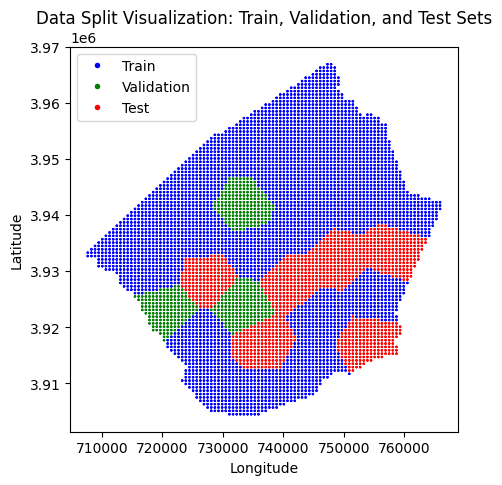

In [ ]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import random
from datetime import datetime
from sklearn.cluster import KMeans
import joblib  
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import itertools

# Set a fixed random seed for reproducibility
random.seed(19)
np.random.seed(19)
torch.manual_seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf_train_test = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

# Extract centroid coordinates of each tile
gdf_train_test['centroid'] = gdf_train_test.geometry.centroid

# Decide on the number of clusters
n_clusters = 30  # Adjust based on your requirements
# Use coordinates without scaling
coords = np.array([[geom.x, geom.y] for geom in gdf_train_test['centroid']])

# Path to save the KMeans model
kmeans_model_path = "../artifacts/kmeans_model.pkl"
# Check if the KMeans model already exists
if os.path.exists(kmeans_model_path):
    # Load the saved KMeans model
    kmeans = joblib.load(kmeans_model_path)
    print("Loaded KMeans model from disk.")
else:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=19)
    kmeans.fit(coords)
    # Save the KMeans model to disk
    joblib.dump(kmeans, kmeans_model_path)
    print("KMeans model trained and saved to disk.")
# Assign clusters to the DataFrame
gdf_train_test['cluster'] = kmeans.predict(coords)

# Get unique clusters
clusters = np.sort(gdf_train_test['cluster'].unique())

# Path to save the cluster-to-set mapping
cluster_to_set_path = "../artifacts/cluster_to_set.pkl"
# Check if the cluster-to-set mapping already exists
if os.path.exists(cluster_to_set_path):
    # Load the saved mapping
    with open(cluster_to_set_path, 'rb') as f:
        cluster_to_set = pkl.load(f)
    print("Loaded cluster-to-set mapping from disk.")
    
    # Recreate the train, validation, and test clusters
    train_clusters = [cluster for cluster, set_type in cluster_to_set.items() if set_type == 'Train']
    val_clusters = [cluster for cluster, set_type in cluster_to_set.items() if set_type == 'Validation']
    test_clusters = [cluster for cluster, set_type in cluster_to_set.items() if set_type == 'Test']
else:
    # Shuffle clusters to randomize the assignment
    np.random.shuffle(clusters)
    
    # Split clusters into train, validation, and test sets
    num_clusters = len(clusters)
    train_size = int(0.7 * num_clusters)
    val_size = int(0.1 * num_clusters)
    test_size = num_clusters - train_size - val_size
    
    train_clusters = clusters[:train_size]
    val_clusters = clusters[train_size:train_size + val_size]
    test_clusters = clusters[train_size + val_size:]
    
    # Create a mapping from clusters to sets
    cluster_to_set = {}
    for cluster in train_clusters:
        cluster_to_set[cluster] = 'Train'
    for cluster in val_clusters:
        cluster_to_set[cluster] = 'Validation'
    for cluster in test_clusters:
        cluster_to_set[cluster] = 'Test'
    
    # Save the cluster-to-set mapping
    with open(cluster_to_set_path, 'wb') as f:
        pkl.dump(cluster_to_set, f)
    print("Cluster-to-set mapping saved to disk.")

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)

# Now you can proceed to split the DataFrame based on the 'set' column
train_gdf = gdf_train_test[gdf_train_test['set'] == 'Train'].reset_index(drop=True)
val_gdf = gdf_train_test[gdf_train_test['set'] == 'Validation'].reset_index(drop=True)
test_gdf = gdf_train_test[gdf_train_test['set'] == 'Test'].reset_index(drop=True)

# Define feature and target columns
X_cols = [col for col in gdf_train_test.columns if col.startswith('feature')]
y_col = 'urban_imperviousness'

# Prepare data arrays for train, validation, and test
X_train = train_gdf[X_cols]
y_train = np.stack(train_gdf[y_col].values).reshape(-1, 3, 3)

X_val = val_gdf[X_cols]
y_val = np.stack(val_gdf[y_col].values).reshape(-1, 3, 3)

X_test = test_gdf[X_cols]
y_test = np.stack(test_gdf[y_col].values).reshape(-1, 3, 3)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 9), dtype=torch.float32)  # Flattened 3x3 grids

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 9), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 9), dtype=torch.float32)

# Create a mapping from clusters to sets
cluster_to_set = {}
for cluster in train_clusters:
    cluster_to_set[cluster] = 'Train'
for cluster in val_clusters:
    cluster_to_set[cluster] = 'Validation'
for cluster in test_clusters:
    cluster_to_set[cluster] = 'Test'

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)

# Display the number of samples in each split
print(f"Number of samples in the training set: {len(train_gdf)}")
print(f"Number of samples in the validation set: {len(val_gdf)}")
print(f"Number of samples in the test set: {len(test_gdf)}")

print("Train data X shape:", X_train.values.shape)
print("Train data y shape:", y_train.shape)

print("Train, validation, and test set target distributions:")
# Training set distribution
print(train_gdf['urban_imperviousness'].describe())
# Validation set distribution
print(val_gdf['urban_imperviousness'].describe())
# Test set distribution
print(test_gdf['urban_imperviousness'].describe())


# Plot the data points colored by 'set'
plt.figure(figsize=(5, 5))

# Define colors for each set
colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}

# Map 'set' labels to colors
point_colors = gdf_train_test['set'].map(colors)

# Plot
plt.scatter(coords[:, 0], coords[:, 1], c=point_colors, s=0.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Validation', markerfacecolor='green', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='red', markersize=5)
]

plt.legend(handles=legend_elements, loc='best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Split Visualization: Train, Validation, and Test Sets')
plt.show()

In [3]:
# Baseline Model

# Calculate the mean urban imperviousness for each cell in the 3x3 grid across the training set
baseline_prediction = np.mean(y_train, axis=0)
print("Baseline prediction (3x3 grid):\n", baseline_prediction)

# Flatten the true and predicted 3x3 grids to apply the metrics for the test set
y_test_flat = y_test.reshape(-1, 9)  # Flatten each 3x3 grid in y_test to a 9-element vector

# Repeat the baseline prediction for each sample in y_test for comparison
baseline_pred = np.tile(baseline_prediction.flatten(), (y_test_flat.shape[0], 1))

# Calculate baseline metrics on the test set
mse_baseline = mean_squared_error(y_test_flat, baseline_pred)
mae_baseline = mean_absolute_error(y_test_flat, baseline_pred)

print(f"Baseline MSE on Test Set: {mse_baseline}")
print(f"Baseline MAE on Test Set: {mae_baseline}")

Baseline prediction (3x3 grid):
 [[0.03193201 0.03298827 0.03228182]
 [0.03320245 0.03320238 0.03282656]
 [0.03361407 0.03371402 0.03321914]]
Baseline MSE on Test Set: 0.0051237172447144985
Baseline MAE on Test Set: 0.03848246484994888


In [4]:
def train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor=None, 
    y_val_tensor=None, 
    epochs=100, 
    criterion=None,  
    optimizer=None, 
    scheduler=None,
    lr=0.001, 
    batch_size=32, 
    verbose=True,
    use_batch_processing=True, 
    early_stopping=False,  
    patience=10,  
    min_delta=0.0 
):
    # Set up criterion if none is provided
    if criterion is None:
        criterion = nn.MSELoss()
    
    # Set up optimizer if none is provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Create DataLoader for batch processing if enabled
    if use_batch_processing:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        # No batch processing; use the entire dataset in each pass
        train_loader = [(X_train_tensor, y_train_tensor)]
    
    # Early stopping initialization
    best_loss = float('inf')
    patience_counter = 0
    
    # Initialize lists to record loss history
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        # Calculate average training loss
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)  # Record training loss
    
        # Validation phase
        if X_val_tensor is not None and y_val_tensor is not None:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)  # Record validation loss
    
            # Adjust learning rate with scheduler
            if scheduler is not None:
                scheduler.step(val_loss)
    
            # Early stopping
            if early_stopping:
                # Check for improvement
                if val_loss < best_loss - min_delta:
                    best_loss = val_loss
                    patience_counter = 0  # Reset patience if there is improvement
                else:
                    patience_counter += 1  # Increment patience if no improvement
    
                # Stop training if patience is exceeded
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch + 1} with Validation Loss: {best_loss:.6f}")
                    break
        else:
            # If no validation data, consider using training loss for scheduler
            if scheduler is not None:
                scheduler.step(avg_loss)
            val_losses.append(None)
    
        # Print epoch loss every 10 epochs if verbose is enabled
        if verbose and (epoch + 1) % 10 == 0:
            msg = f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.6f}'
            if X_val_tensor is not None and y_val_tensor is not None:
                msg += f', Validation Loss: {val_loss:.6f}'
            print(msg)
    
    return model, train_losses, val_losses

def plot_train_val_losses(train_losses, val_losses):
    # Create a range for the number of epochs
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(6, 3))
    plt.plot(epochs_range, train_losses, label='Training Loss')
    # Check if validation losses are recorded (not None)
    if any(v is not None for v in val_losses):
        plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

# Simple fully connected (dense) neural network 
class SimpleNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Deep Fully Connected Neural Network
class DeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128, dropout_rate=0.5):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6)
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

# Define hyperparameter grid
hyperparameter_grid = {
    'model_type': ['SimpleNN', 'DeepNN'],
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'weight_decay': [0, 1e-5, 1e-4],
    'learning_rate': [0.0005, 0.001],
    'patience': [10, 20, 30],
    'criterion': ['MSELoss', 'SmoothL1Loss'],  # Loss functions to try
}

# Generate all combinations of hyperparameters
hyperparameter_list = list(itertools.product(
    hyperparameter_grid['model_type'],
    hyperparameter_grid['hidden_units'],
    hyperparameter_grid['dropout_rate'],
    hyperparameter_grid['weight_decay'],
    hyperparameter_grid['learning_rate'],
    hyperparameter_grid['patience'],
    hyperparameter_grid['criterion'],
))

In [5]:
# Directory to save models
model_dir = '../artifacts/iterative_models'
os.makedirs(model_dir, exist_ok=True)

# Function to create a unique model name
def create_model_name(params):
    model_name = f"{params['model_type']}_hu{params['hidden_units']}_dr{params['dropout_rate']}_wd{params['weight_decay']}_lr{params['learning_rate']}_pat{params['patience']}_crit{params['criterion']}"
    return model_name

In [ ]:
# Loop over hyperparameter combinations
for hp_values in hyperparameter_list:
    # Create a dictionary of hyperparameters
    params = {
        'model_type': hp_values[0],
        'hidden_units': hp_values[1],
        'dropout_rate': hp_values[2],
        'weight_decay': hp_values[3],
        'learning_rate': hp_values[4],
        'patience': hp_values[5],
        'criterion': hp_values[6],
    }
    
    # Create a unique model name
    model_name = create_model_name(params)
    model_filepath = os.path.join(model_dir, model_name + '.pkl')
    
    # Check if model already exists
    if os.path.exists(model_filepath):
        # print(f"Model {model_name} already exists. Skipping training.")
        continue  # Skip to the next hyperparameter combination
    
    print(f"Training model {model_name}...")
    
    # Define the model based on model_type
    if params['model_type'] == 'SimpleNN':
        model = SimpleNN(input_size=768, 
                         output_size=9,
                         hidden_units=params['hidden_units'], 
                         dropout_rate=params['dropout_rate'])
    
    elif params['model_type'] == 'DeepNN':
        model = DeepNN(input_size=768, 
                       output_size=9, 
                       hidden_units=params['hidden_units'], 
                       dropout_rate=params['dropout_rate'])
    else:
        print(f"Unknown model type: {params['model_type']}. Skipping.")
        continue  # Skip to the next hyperparameter combination
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), 
                           lr=params['learning_rate'], 
                           weight_decay=params['weight_decay'])
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Define criterion
    if params['criterion'] == 'MSELoss':
        criterion = nn.MSELoss()
    elif params['criterion'] == 'SmoothL1Loss':
        criterion = nn.SmoothL1Loss()
    else:
        print(f"Unknown criterion: {params['criterion']}. Skipping.")
        continue  # Skip to the next hyperparameter combination
    
    # Train the model
    trained_model, train_losses, val_losses = train_model(
        model=model,
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_val_tensor=X_val_tensor,
        y_val_tensor=y_val_tensor,
        epochs=100,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        lr=params['learning_rate'],
        batch_size=64,
        verbose=False,  # Set to False to reduce output
        use_batch_processing=True,
        early_stopping=True,
        patience=params['patience'],
        min_delta=0.0001
    )
    
    # Prediction on test data
    with torch.no_grad():
        test_pred = trained_model(X_test_tensor)
    
    # Calculate metrics
    mse = nn.MSELoss()(test_pred, y_test_tensor).item()
    mae = nn.L1Loss()(test_pred, y_test_tensor).item()
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}\nRMSE: {rmse}\nMAE: {mae}")

    # Save all artifacts
    artifacts = {
        'model_name': model_name,
        'hyperparameters': params,
        'model_state_dict': trained_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_predictions': test_pred.numpy(),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
    }
    
    with open(model_filepath, 'wb') as f:
        pkl.dump(artifacts, f)
    
    print(f"Model {model_name} trained and saved.")

In [ ]:
# Collect metrics from all saved models
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

metrics_list = []
for model_file in model_files:
    with open(model_file, 'rb') as f:
        artifacts = pkl.load(f)
    metrics = {
        'model_name': artifacts['model_name'],
        'mse': artifacts['mse'],
        'mae': artifacts['mae'],
        'rmse': artifacts['rmse'],
        'hyperparameters': artifacts['hyperparameters'],
    }
    metrics_list.append(metrics)


In [75]:
def extract_top_hyperparameters(df, metric_columns, top_n=10):
    # Select the top `n` rows based on the first metric column
    top_df = df.head(top_n)
    
    # Expand the 'hyperparameters' column into separate columns
    hyperparams_df = top_df['hyperparameters'].apply(pd.Series)
    
    # Remove 'model_name' and directly include 'model_type' from hyperparameters
    top_df = pd.concat([hyperparams_df, top_df[metric_columns]], axis=1)
    
    # Ensure the column order is as required
    reordered_columns = ['model_type'] + metric_columns + [col for col in hyperparams_df.columns if col != 'model_type']
    top_df = top_df[reordered_columns]
    
    return top_df

# Example usage:
metric_cols = ['rmse', 'mse', 'mae']
extract_top_hyperparameters(pd.DataFrame(metrics_list).sort_values(by='rmse').reset_index(drop=True), metric_cols, top_n=10)

,model_type,rmse,mse,mae,hidden_units,dropout_rate,weight_decay,learning_rate,patience,criterion
0,DeepNN,0.044804,0.002007,0.020944,128,0.1,0.00010,0.0005,10,MSELoss
1,DeepNN,0.045075,0.002032,0.019629,64,0.1,0.00000,0.0005,10,MSELoss
2,DeepNN,0.045246,0.002047,0.019230,128,0.2,0.00010,0.0005,20,MSELoss
3,DeepNN,0.045267,0.002049,0.021024,64,0.1,0.00010,0.0010,10,SmoothL1Loss
4,DeepNN,0.045280,0.002050,0.018625,64,0.1,0.00010,0.0010,10,MSELoss
5,DeepNN,0.045294,0.002052,0.021355,128,0.1,0.00010,0.0010,20,SmoothL1Loss
6,DeepNN,0.045333,0.002055,0.019080,128,0.1,0.00010,0.0005,20,SmoothL1Loss
7,DeepNN,0.045344,0.002056,0.019574,128,0.1,0.00000,0.0005,10,MSELoss
8,DeepNN,0.045348,0.002056,0.020340,64,0.1,0.00001,0.0005,10,MSELoss
9,DeepNN,0.045364,0.002058,0.020052,128,0.1,0.00010,0.0010,30,MSELoss


In [76]:
extract_top_hyperparameters(pd.DataFrame(metrics_list).sort_values(by='mae').reset_index(drop=True), metric_cols, top_n=10)

,model_type,rmse,mse,mae,hidden_units,dropout_rate,weight_decay,learning_rate,patience,criterion
0,DeepNN,0.046279,0.002142,0.018234,128,0.1,0.00001,0.0005,10,SmoothL1Loss
1,DeepNN,0.048158,0.002319,0.018251,32,0.5,0.00010,0.0010,30,SmoothL1Loss
2,DeepNN,0.048167,0.002320,0.018305,64,0.5,0.00010,0.0005,30,MSELoss
3,SimpleNN,0.047685,0.002274,0.018344,64,0.5,0.00010,0.0010,20,SmoothL1Loss
4,DeepNN,0.048528,0.002355,0.018346,32,0.3,0.00010,0.0005,30,MSELoss
5,SimpleNN,0.048867,0.002388,0.018349,32,0.5,0.00010,0.0010,30,SmoothL1Loss
6,SimpleNN,0.049285,0.002429,0.018403,32,0.5,0.00010,0.0010,30,MSELoss
7,SimpleNN,0.048418,0.002344,0.018406,32,0.3,0.00010,0.0010,30,MSELoss
8,SimpleNN,0.046201,0.002135,0.018451,64,0.3,0.00010,0.0010,20,MSELoss
9,SimpleNN,0.046934,0.002203,0.018472,32,0.3,0.00001,0.0005,20,MSELoss


In [8]:
train_val_losses = {}
for model_file in model_files:
    with open(model_file, "rb") as f:
        artifacts = pkl.load(f)
    train_val_losses.update(
        {
            artifacts["model_name"]: {
                "train_losses": artifacts["train_losses"],
                "val_losses": artifacts["val_losses"],
            }
        }
    )

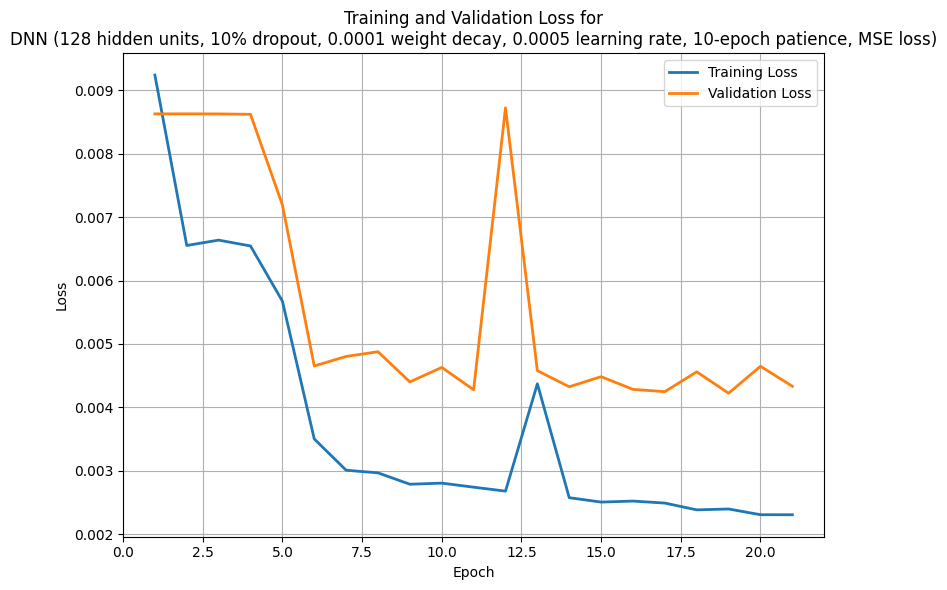

In [13]:
def plot_training_validation_loss(train_losses, val_losses, model_name="Model"):
    """
    Plots the training and validation loss over epochs.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch. Can include `None` for epochs without validation.
        model_name (str): Name of the model for the plot title.
    """
    # Create a range for the number of epochs
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", linewidth=2)
    
    # Include validation loss if provided
    if any(v is not None for v in val_losses):
        plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for\n{model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
plot_training_validation_loss(
    train_losses=train_val_losses[metrics_df.iloc[0]["model_name"]]['train_losses'],
    val_losses=train_val_losses[metrics_df.iloc[0]["model_name"]]['val_losses'],
    model_name="DNN (128 hidden units, 10% dropout, 0.0001 weight decay, 0.0005 learning rate, 10-epoch patience, MSE loss)"
)


C:\Users\bento\AppData\Local\Temp\ipykernel_10316\507146985.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


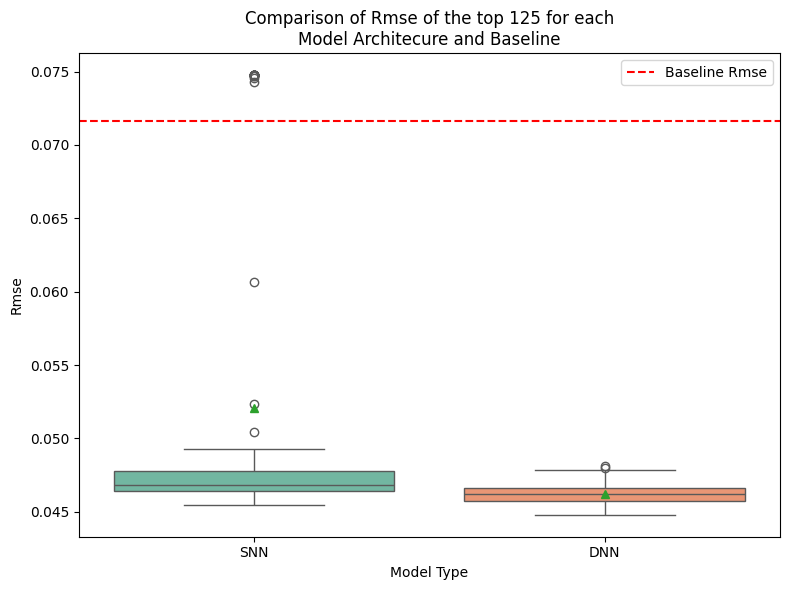

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_models(metrics_df, baseline_metric, metric='rmse', top_n=5):
    """
    Plots side-by-side boxplots comparing the specified metric for the top SNN, DNN models, and baseline.

    Parameters:
        metrics_df (pd.DataFrame): DataFrame containing model metrics and names.
        baseline_metric (float): The baseline metric value (e.g., baseline RMSE).
        metric (str): The metric to compare (e.g., 'rmse', 'mse', 'mae').
        top_n (int): Number of top models to consider for each architecture.
    """
    # Separate models into SNN and DNN based on model name
    snn_models = metrics_df[metrics_df['model_name'].str.contains('SimpleNN')].nsmallest(top_n, metric)
    dnn_models = metrics_df[metrics_df['model_name'].str.contains('DeepNN')].nsmallest(top_n, metric)
    
    # Prepare data for plotting
    data = {
        'Model Type': ['Baseline'] * 1 + ['SNN'] * top_n + ['DNN'] * top_n,
        metric.capitalize(): [baseline_metric] + snn_models[metric].tolist() + dnn_models[metric].tolist()
    }
    plot_df = pd.DataFrame(data)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # Create boxplots for SNN and DNN
    sns.boxplot(
        x='Model Type', 
        y=metric.capitalize(), 
        data=plot_df, 
        order=['SNN', 'DNN'], 
        showmeans=True,
        palette='Set2'
    )
    
    # Add the baseline as a horizontal line
    plt.axhline(baseline_metric, color='red', linestyle='--', label=f'Baseline {metric.capitalize()}')
    
    # Add plot details
    plt.title(f"Comparison of {metric.capitalize()} of the top {top_n} for each\nModel Architecure and Baseline")
    plt.ylabel(metric.capitalize())
    plt.xlabel("Model Type")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage:
baseline_rmse = 0.07162  # Example baseline RMSE value
compare_models(metrics_df, baseline_rmse, metric='rmse', top_n=125)


In [36]:
import torch

def load_model_by_name(model_name, model_dir='../artifacts/iterative_models'):
    """
    Load a specific model by its name.

    Args:
        model_name (str): The name of the model to load.
        model_dir (str): Path to the directory containing the saved model artifacts.

    Returns:
        model (torch.nn.Module): The loaded PyTorch model ready for predictions.
        artifacts (dict): The associated artifacts including hyperparameters and metrics.
    """
    # Construct the file path for the model
    model_filepath = os.path.join(model_dir, model_name + '.pkl')
    
    # Check if the file exists
    if not os.path.exists(model_filepath):
        raise FileNotFoundError(f"Model '{model_name}' not found in {model_dir}.")
    
    # Load the artifacts
    with open(model_filepath, 'rb') as f:
        artifacts = pkl.load(f)
    
    # Recreate the model based on the saved hyperparameters
    params = artifacts['hyperparameters']
    if params['model_type'] == 'SimpleNN':
        model = SimpleNN(input_size=768, 
                         output_size=9, 
                         hidden_units=params['hidden_units'], 
                         dropout_rate=params['dropout_rate'])
    elif params['model_type'] == 'DeepNN':
        model = DeepNN(input_size=768, 
                       output_size=9, 
                       hidden_units=params['hidden_units'], 
                       dropout_rate=params['dropout_rate'])
    else:
        raise ValueError(f"Unknown model type: {params['model_type']}.")
    
    # Load the model's state dictionary
    model.load_state_dict(artifacts['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    
    print(f"Model '{model_name}' successfully loaded.")
    return model, artifacts


# Get the top model name from metrics_df
top_model_name = metrics_df.iloc[0]['model_name']

# Load the top model
top_model, top_model_artifacts = load_model_by_name(top_model_name)

# Example: Generate predictions
with torch.no_grad():
    predictions = top_model(X_test_tensor)
print("Predictions:", predictions)

Model 'DeepNN_hu128_dr0.1_wd0.0001_lr0.0005_pat10_critMSELoss' successfully loaded.
Predictions: tensor([[0.0034, 0.0054, 0.0060,  ..., 0.0013, 0.0018, 0.0035],
        [0.0065, 0.0105, 0.0115,  ..., 0.0027, 0.0039, 0.0069],
        [0.0070, 0.0065, 0.0063,  ..., 0.0027, 0.0027, 0.0036],
        ...,
        [0.0011, 0.0017, 0.0023,  ..., 0.0006, 0.0008, 0.0016],
        [0.0029, 0.0035, 0.0044,  ..., 0.0015, 0.0020, 0.0030],
        [0.0022, 0.0025, 0.0027,  ..., 0.0009, 0.0011, 0.0015]])


In [ ]:
from PIL import Image
import re
from IPython import display

def array_to_raster(array, crs, xmin, ymin, xmax, ymax, output_path):
    """Convert a numpy array to a raster file on disk."""
    
    # Define the transform based on bounds and array dimensions
    transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, array.shape[1], array.shape[0])

    # Define the profile for the output raster
    profile = {
        'driver': 'GTiff',
        'height': array.shape[0],
        'width': array.shape[1],
        'count': 1,
        'dtype': array.dtype,
        'crs': crs,
        'transform': transform,
    }

    # Save raster directly to disk
    with rasterio.open(output_path, "w", **profile) as dataset:
        dataset.write(array, 1)  # Write the array to the first band
    # print(f"Raster saved to {output_path}")

def generate_prediction_rasters(predictions, gdf, crs, output_dir):
    """
    Generate and save prediction rasters for each tile in a specific date.
    
    Parameters:
    - predictions (array): Predicted arrays for each tile.
    - gdf (GeoDataFrame): GeoDataFrame with tile bounds and other metadata.
    - crs: Coordinate reference system for the output raster.
    - output_dir (str): Directory to save the rasters.
    """
    for i, pred in enumerate(predictions):
        # Define bounds for this tile from the gdf
        xmin, ymin, xmax, ymax = gdf.iloc[i][['min_x', 'min_y', 'max_x', 'max_y']]
        
        # Define the output path for the tile
        raster_path = os.path.join(output_dir, f"prediction_tile_{i}.tif")
        
        if not os.path.exists(raster_path):
            # Convert prediction array to a raster and save it directly to disk
            array_to_raster(pred, crs, xmin, ymin, xmax, ymax, raster_path)


def merge_subdivided_tiles(input_tile_dir, output_merged_file):
    """
    Merge all subdivided tiles in the input directory into a single raster file.

    Parameters:
    - input_tile_dir (str): The directory containing the subdivided tiles (.tif files).
    - output_merged_file (str): The path to save the merged raster file.
    """
    # Collect all the .tif files in the input directory
    tile_files = glob.glob(os.path.join(input_tile_dir, "*.tif"))
    
    if not tile_files:
        print(f"No .tif files found in {input_tile_dir}")
        return
    
    # List to hold the opened rasterio datasets
    src_files_to_merge = []

    for tif in tile_files:
        src = rasterio.open(tif)
        src_files_to_merge.append(src)

    # Perform the merge
    mosaic, out_trans = merge(src_files_to_merge)

    # Get metadata from one of the source files
    out_meta = src_files_to_merge[0].meta.copy()

    # Update the metadata to reflect the new dimensions, transform, and CRS
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0],  # Update count to match the number of bands in the mosaic
        "dtype": mosaic.dtype  # Make sure the data type is set properly
    })

    # Write the merged raster to disk, ensuring all bands are written correctly
    with rasterio.open(output_merged_file, "w", **out_meta) as dest:
        for i in range(1, mosaic.shape[0] + 1):
            dest.write(mosaic[i - 1], i)

    # Close the opened files
    for src in src_files_to_merge:
        src.close()

    print(f"Merged raster saved to {output_merged_file}")

def plot_merged_raster(gdf_tiles, merged_raster_path, county_boundary_path="../data/county_boundary.shp",
                       figsize=(10, 10), title='Urban Imperviousness Predictions', save_path=None):
    # Paths and variables
    county_boundary = gpd.read_file(county_boundary_path)
    mosaic = rasterio.open(merged_raster_path)

    # Mask the mosaic data to limit it to the county boundary
    county_geom = [gdf_tiles.geometry.union_all()]  # Convert to list for mask function
    data, transform = mask(mosaic, county_geom, crop=False, filled=True, nodata=-1)
    data = data.astype('float32')
    data[data == -1.] = np.nan  # Replace -1 with NaN for visualization


    # Create a reversed colormap with white for NaNs
    cmap = plt.cm.inferno.reversed()
    cmap.set_bad(color='#fefefe')  # Set NaN values to appear white

    # Plot the mosaic with NA color set to white
    fig, ax = plt.subplots(figsize=figsize)
    img = rasterio.plot.show(data, transform=transform, ax=ax, cmap=cmap)

    # Plot the county boundary and tile boundaries
    county_boundary.plot(ax=ax, facecolor='none', edgecolor='#121212', linewidth=1.)
    gdf_tiles.boundary.plot(ax=ax, edgecolor='#030303', linewidth=0.5, alpha=0.3)

    # Create a ScalarMappable for the color bar (Urban Imperviousness)
    norm = Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
    sm = ScalarMappable(norm=norm, cmap=cmap)

    # Create custom legend elements for County Boundary and Tile Boundary
    legend_elements = [
        Line2D([0], [0], color='#121212', lw=1., label='County Boundary'),
        Line2D([0], [0], color='#030303', lw=0.5, label='Tile Boundary', alpha=0.3),
    ]

    # Add the legend for County Boundary and Tile Boundary outside the plot
    legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), frameon=True)

    # Position the color bar to the right of the plot to represent Urban Imperviousness
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.035, pad=0.04)
    cbar.set_label('Urban Imperviousness')

    # Title and labels
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()


def gen_predicted_rasters(gdf, timestamp, model, data_dir="../data", 
                          prediction_raster_dir_prefix="prediction_rasters", 
                          merged_file_prefix="merged_urban_raster",
                          model_name='',
                          plot_dir="../docs/plots"):
    if model_name != '' and not model_name.startswith('_'):
        model_name = '_' + model_name
    gdf_selected = gdf.loc[gdf['date'] == pd.Timestamp(timestamp)]\
        .sort_values(by="tile_index").reset_index(drop=True)
    gdf_selected_X = torch.tensor(gdf_selected[X_cols].values, dtype=torch.float32)
    
    with torch.no_grad():
        gdf_pred = model(gdf_selected_X).reshape(-1, 3, 3).numpy()
    print("Predicted output shape:", gdf_pred.shape)
    
    # Create timestamp suffix for the output directory and files
    date_obj = pd.Timestamp(timestamp)
    timestamp_suffix = f"_{date_obj.strftime('%b').lower()}_{date_obj.year}"
    output_dir = os.path.join(data_dir, prediction_raster_dir_prefix + model_name + timestamp_suffix)
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate predictions and save as rasters
    generate_prediction_rasters(gdf_pred, gdf_selected, gdf_selected.crs, output_dir)

    # Define the output path for the merged file
    output_merged_file = os.path.join(data_dir, merged_file_prefix + model_name + timestamp_suffix + "_pred.tif")
    
    if not os.path.exists(output_merged_file):
        # Merge the subdivided tiles
        merge_subdivided_tiles(output_dir, output_merged_file)
    
    # Make a directory to save PNG plot (if needed)
    os.makedirs(plot_dir, exist_ok=True)
    # Define plot path 
    plot_file_path = os.path.join(plot_dir, "urban_imperviousness_pred" + model_name + timestamp_suffix + ".png")

    # Format month and year for the plot title
    month_year = date_obj.strftime('%b %Y')
    plot_title = f'Urban Imperviousness {month_year} Predictions'
    
    # Plot and save the merged raster, and save the plot as a PNG file
    plot_merged_raster(gdf_selected, output_merged_file, title=plot_title, save_path=plot_file_path)

    return plot_file_path


def pngs_to_gif(input_folder, output_gif, prefix, duration=500, loop=0):
    """
    Convert PNG files with a specific prefix and date-sorted suffix into a GIF.

    Parameters:
    - input_folder (str): Path to the folder containing PNG files.
    - output_gif (str): Path to save the output GIF file.
    - prefix (str): The prefix to filter PNG files (e.g., "some_text_").
    - duration (int): Duration of each frame in milliseconds (default is 500ms).
    - loop (int): Number of times the GIF should loop. 0 means infinite loop.
    """
    # Regular expression to match files with the prefix and date suffix (four-digit year)
    pattern = re.compile(f"{prefix}_(\\w+)_(\\d{{4}}).png$")

    # List to hold (filename, date) tuples
    date_files = []

    for file_name in os.listdir(input_folder):
        # Check if the file name matches the expected pattern
        match = pattern.search(file_name)
        if match:
            # Extract month and year from the suffix and parse it into a date
            date_str = f"{match.group(1)} {match.group(2)}"
            try:
                file_date = datetime.strptime(date_str, "%b %Y")
                date_files.append((file_name, file_date))
            except ValueError:
                print(f"Skipping {file_name}: Invalid date format.")
    
    # Sort files by extracted date
    date_files.sort(key=lambda x: x[1])

    # Load sorted images
    frames = [Image.open(os.path.join(input_folder, file_name)) for file_name, _ in date_files]

    if frames:
        # Save as GIF
        frames[0].save(output_gif, format='GIF', append_images=frames[1:], save_all=True, duration=duration, loop=loop)
        print(f"GIF saved to {output_gif}")
    else:
        print("No matching files found to create GIF.")


# for d in gdf['date'].unique():
#     if d not in gdf_train_test['date']:
#         gen_predicted_rasters(gdf, d, top_model, model_name=top_model_name)

# Example usage
# pngs_to_gif("../docs/plots", f"../docs/plots/{top_model_name}.gif", prefix="urban_imperviousness_pred_dnn", duration=300, loop=0)

# Display the GIF file directly
display.display(display.Image(filename=f"../docs/plots/{top_model_name}.gif"))


In [39]:
def calculate_summary_statistics(gdf, model, dates, model_name='', X_cols=None):
    """
    Calculate summary statistics for predicted urban imperviousness for each date.
    
    Parameters:
    - gdf (GeoDataFrame): GeoDataFrame containing the data.
    - model (torch.nn.Module): Trained model for predictions.
    - dates (list): List of unique dates to process.
    - model_name (str): Name of the model for reference (optional).
    - X_cols (list): List of feature column names.
    
    Returns:
    - stats_df (DataFrame): DataFrame containing summary statistics for each date.
    """
    # List to store summary statistics for each date
    stats = []

    for date in dates:
        # Select the data for the given date
        gdf_selected = gdf.loc[gdf['date'] == pd.Timestamp(date)].reset_index(drop=True)
        gdf_selected_X = torch.tensor(gdf_selected[X_cols].values, dtype=torch.float32)
        
        # Generate predictions
        with torch.no_grad():
            predictions = model(gdf_selected_X).reshape(-1, 9).numpy()  # Flatten the 3x3 grid for each tile
        
        # Calculate summary statistics
        mean_val = predictions.mean()
        median_val = np.median(predictions)
        variance_val = np.var(predictions)
        min_val = predictions.min()
        max_val = predictions.max()
        
        # Store the statistics in a dictionary
        stats.append({
            'date': date,
            'mean': mean_val,
            'median': median_val,
            'variance': variance_val,
            'min': min_val,
            'max': max_val
        })
    
    # Convert the list of dictionaries to a pandas DataFrame
    stats_df = pd.DataFrame(stats)
    return stats_df


# `gdf` contains the dataset, `top_model` is the trained model, and `X_cols` are the feature columns
dates_to_process = [d for d in gdf['date'].unique() if d not in gdf_train_test['date']]

stats_df = calculate_summary_statistics(gdf, top_model, dates_to_process, model_name=top_model_name, X_cols=X_cols)

# Display the summary statistics DataFrame
stats_df


,date,mean,median,variance,min,max
0,2016-04-14 15:59:22,0.032846,0.011562,0.004127,0.000188,0.663061
1,2016-06-10 15:54:12,0.031516,0.011655,0.003758,0.000240,0.677976
2,2016-11-27 15:56:12,0.033565,0.013419,0.003807,0.000144,0.665904
3,2017-08-19 15:48:59,0.031707,0.010540,0.003786,0.000138,0.637849
4,2017-11-30 16:06:19,0.037433,0.015399,0.004353,0.000232,0.658085
5,2018-03-15 16:00:21,0.039075,0.015265,0.004812,0.000289,0.638224
6,2018-08-07 15:58:59,0.032488,0.010461,0.004092,0.000126,0.668883
7,2019-07-03 15:58:29,0.039410,0.015156,0.004690,0.000164,0.694747
8,2019-12-05 16:06:41,0.041281,0.016732,0.005003,0.000203,0.668857
9,2020-04-03 15:59:01,0.038173,0.013143,0.005016,0.000258,0.659465


In [43]:
def calculate_yearly_summary_statistics(gdf, model, X_cols=None, max_year=2023):
    """
    Calculate yearly summary statistics for predicted urban imperviousness.
    
    Parameters:
    - gdf (GeoDataFrame): GeoDataFrame containing the data.
    - model (torch.nn.Module): Trained model for predictions.
    - X_cols (list): List of feature column names.
    - max_year (int): Maximum year to include in the statistics.
    
    Returns:
    - stats_df (DataFrame): DataFrame containing yearly summary statistics.
    """
    # Add a 'year' column to the GeoDataFrame
    gdf['year'] = gdf['date'].dt.year
    
    # Filter data up to the max_year
    gdf_filtered = gdf[gdf['year'] <= max_year]
    
    # Group the GeoDataFrame by year
    yearly_groups = gdf_filtered.groupby('year')
    
    # List to store summary statistics for each year
    stats = []
    
    for year, group in yearly_groups:
        # Prepare data for predictions
        gdf_selected_X = torch.tensor(group[X_cols].values, dtype=torch.float32)
        
        # Generate predictions
        with torch.no_grad():
            predictions = model(gdf_selected_X).reshape(-1, 9).numpy()  # Flatten the 3x3 grid for each tile
        
        # Calculate summary statistics
        mean_val = predictions.mean()
        median_val = np.median(predictions)
        variance_val = np.var(predictions)
        min_val = predictions.min()
        max_val = predictions.max()
        
        # Store the statistics in a dictionary
        stats.append({
            'year': year,
            'mean': mean_val,
            'median': median_val,
            'variance': variance_val,
            'min': min_val,
            'max': max_val
        })
    
    # Convert the list of dictionaries to a pandas DataFrame
    stats_df = pd.DataFrame(stats)
    return stats_df

# Calculate yearly summary statistics
yearly_stats_df = calculate_yearly_summary_statistics(
    gdf, 
    top_model, 
    X_cols=X_cols, 
    max_year=2023
)

yearly_stats_df

,year,mean,median,variance,min,max
0,2016,0.032643,0.012233,0.003898,0.000144,0.677976
1,2017,0.034570,0.013033,0.004078,0.000138,0.658085
2,2018,0.035781,0.012887,0.004463,0.000126,0.668883
3,2019,0.040345,0.015974,0.004848,0.000164,0.694747
4,2020,0.037805,0.013183,0.004862,0.000170,0.666720
5,2021,0.040813,0.015124,0.005218,0.000155,0.693998
6,2022,0.040882,0.016698,0.004596,0.000260,0.703639
7,2023,0.038057,0.014865,0.004296,0.000190,0.686122


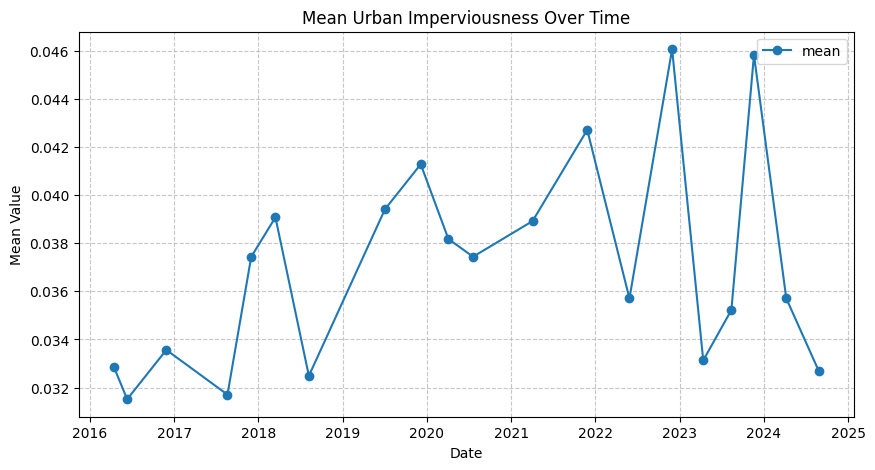

In [40]:

def plot_summary_statistics(stats_df, column, title=None, ylabel=None, 
                            xlabel='Date', figsize=(10, 5), save_path=None):
    """
    Plot a summary statistic over time.

    Parameters:
    - stats_df (DataFrame): DataFrame containing summary statistics with a 'date' column.
    - column (str): Column name to plot on the y-axis.
    - title (str): Title for the plot (optional).
    - ylabel (str): Label for the y-axis (optional).
    - xlabel (str): Label for the x-axis (default: 'Date').
    - figsize (tuple): Figure size (default: (10, 5)).
    - save_path (str): File path to save the plot (optional).
    """
    # Ensure the 'date' column is sorted
    stats_df = stats_df.sort_values(by='date')

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(stats_df['date'], stats_df[column], marker='o', linestyle='-', label=column)

    # Formatting the plot
    plt.title(title if title else f'{column.capitalize()} Over Time')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel else column.capitalize())
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Example: Plot the 'mean' column over time
plot_summary_statistics(
    stats_df=stats_df,
    column='mean',
    title='Mean Urban Imperviousness Over Time',
    ylabel='Mean Value'
)


In [42]:
# https://data.census.gov
values = [190843,196374,202692,209339, 215999, 217723, 234778, 241955]

# Calculate percentage changes
percent_changes = [(values[i] - values[i - 1]) / values[i - 1] * 100 for i in range(1, len(values))]

# Calculate the average percentage change
average_percent_change = sum(percent_changes) / len(percent_changes)

average_percent_change

3.4663937792947754

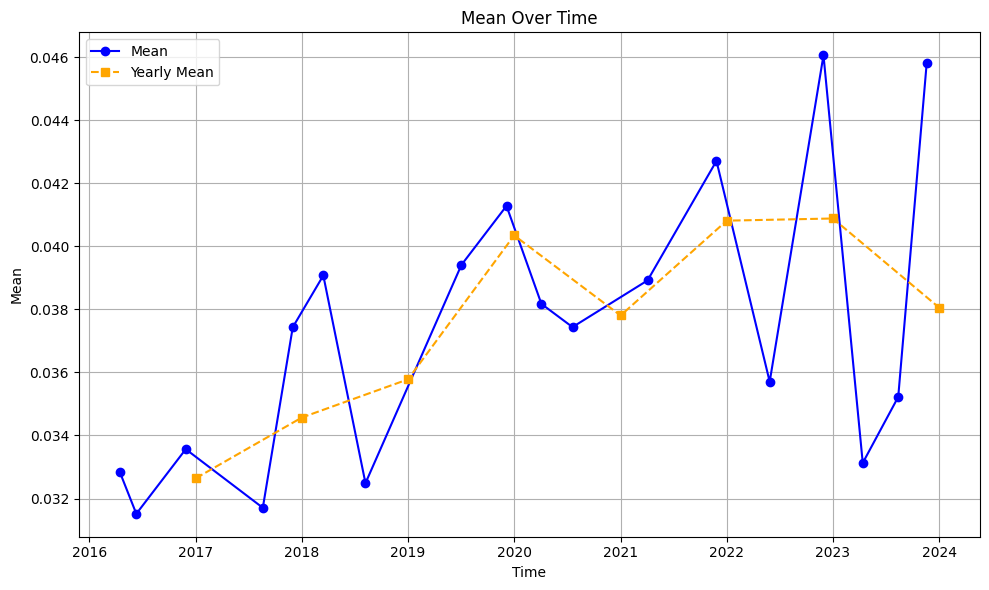

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_statistics(stats_df, yearly_stats_df, column, max_year=2023, figsize=(10, 6)):
    """
    Plot original and yearly statistics for a given column.
    
    Parameters:
    - stats_df (DataFrame): Original summary statistics DataFrame.
    - yearly_stats_df (DataFrame): Yearly summary statistics DataFrame.
    - column (str): The column to plot.
    - max_year (int): Maximum year to include in the plot.
    - figsize (tuple): Figure size for the plot.
    """
    # Filter both DataFrames for the max_year
    stats_df_filtered = stats_df[stats_df['date'].dt.year <= max_year]
    yearly_stats_df_filtered = yearly_stats_df[yearly_stats_df['year'] <= max_year]
    
    # Convert 'year' column in yearly_stats_df to a datetime object
    yearly_stats_df_filtered['date'] = pd.to_datetime(yearly_stats_df_filtered['year'] + 1, format='%Y')
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot the original statistics
    plt.plot(
        stats_df_filtered['date'], 
        stats_df_filtered[column], 
        label=f"{column.capitalize()}",
        marker='o', 
        linestyle='-', 
        color='blue'
    )
    
    # Plot the yearly statistics
    plt.plot(
        yearly_stats_df_filtered['date'], 
        yearly_stats_df_filtered[column], 
        label=f"Yearly {column.capitalize()}",
        marker='s', 
        linestyle='--', 
        color='orange'
    )
    
    # Add labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel(column.capitalize())
    plt.title(f"{column.capitalize()} Over Time")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_statistics(stats_df, yearly_stats_df, column='mean', max_year=2023)


In [50]:
def calculate_average_percent_change(stats_df, yearly_stats_df, column, max_year=2023):
    """
    Calculate the average percentage change in the given statistic per year up through max_year.
    
    Parameters:
    - stats_df (DataFrame): Original summary statistics DataFrame.
    - yearly_stats_df (DataFrame): Yearly summary statistics DataFrame.
    - column (str): The column for which to calculate percentage changes.
    - max_year (int): Maximum year to include in the calculation.
    
    Returns:
    - avg_percent_change (float): The average yearly percentage change.
    """
    # Filter for the specified year range
    yearly_stats_df_filtered = yearly_stats_df[yearly_stats_df['year'] <= max_year]
    
    # Calculate the yearly percentage change
    yearly_stats_df_filtered['percent_change'] = yearly_stats_df_filtered[column].pct_change() * 100
    
    # Calculate the average percentage change, ignoring NaN values
    avg_percent_change = yearly_stats_df_filtered['percent_change'].mean()
    
    return avg_percent_change

# Example usage:
avg_percent_change = calculate_average_percent_change(stats_df, yearly_stats_df, column='mean', max_year=2023)
print(f"Average Percentage Change (up to 2023): {avg_percent_change:.2f}%")


Average Percentage Change (up to 2023): 2.44%
